In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [2]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

In [3]:
from vaneska.models import Gaussian
from vaneska.photometry import PSFPhotometry

In [4]:
from lightkurve import KeplerTargetPixelFile, LightCurve

In [5]:
tpf = KeplerTargetPixelFile.from_archive('kepler-10b', quarter=5)

INFO: Found cached file ./mastDownload/Kepler/kplr011904151_lc_Q111111110111011101/kplr011904151-2010174085026_lpd-targ.fits.gz with expected size 4685387. [astroquery.query]


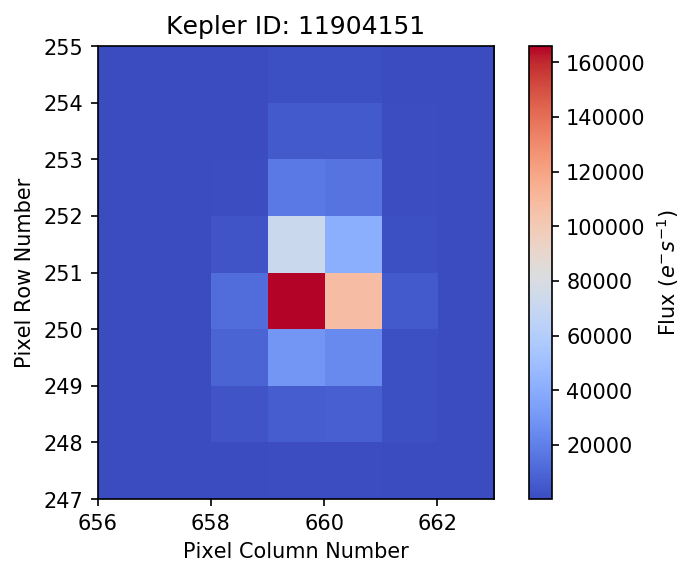

In [6]:
tpf.plot(scale=None, bkg=True, cmap='coolwarm')

In [7]:
gaussian = Gaussian(shape=tpf.shape[1:], col_ref=tpf.column, row_ref=tpf.row)

In [8]:
flux = tf.Variable(np.sum(tpf.flux[0]), dtype=tf.float64, name='flux')
col = tf.Variable(tpf.column+3.85, dtype=tf.float64, name='col')
row = tf.Variable(tpf.row+3.74, dtype=tf.float64, name='row')
a = tf.Variable(1., dtype=tf.float64, name='a')
b = tf.Variable(.0, dtype=tf.float64, name='b')
c = tf.Variable(1., dtype=tf.float64, name='c')
bkg = tf.Variable(np.mean(tpf.flux_bkg[0]), dtype=tf.float64, name='bkg')

In [9]:
mean = gaussian(flux, col, row, a, b, c) + bkg

In [10]:
data = tf.placeholder(dtype=tf.float64)

In [11]:
# Poisson likelihood
loss = tf.reduce_sum(tf.subtract(mean, tf.multiply(data, tf.log(mean))))

In [12]:
var_list=[flux, col, row, a, b, c, bkg]

In [13]:
optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss=loss, var_list=var_list, method='TNC')

In [14]:
with tf.Session() as session:
    session.run(fetches=tf.global_variables_initializer())
    phot = PSFPhotometry(optimizer=optimizer)
    results = phot.fit(pixel_flux=tpf.flux + tpf.flux_bkg, data_placeholder=data,
                       var_list=var_list, session=session)

100%|██████████| 4492/4492 [02:32<00:00, 29.50it/s]


In [15]:
lc_psf = LightCurve(tpf.time, results[:, 0]).flatten().fold(0.837495)

In [16]:
lc = tpf.to_lightcurve().flatten().fold(0.837495)

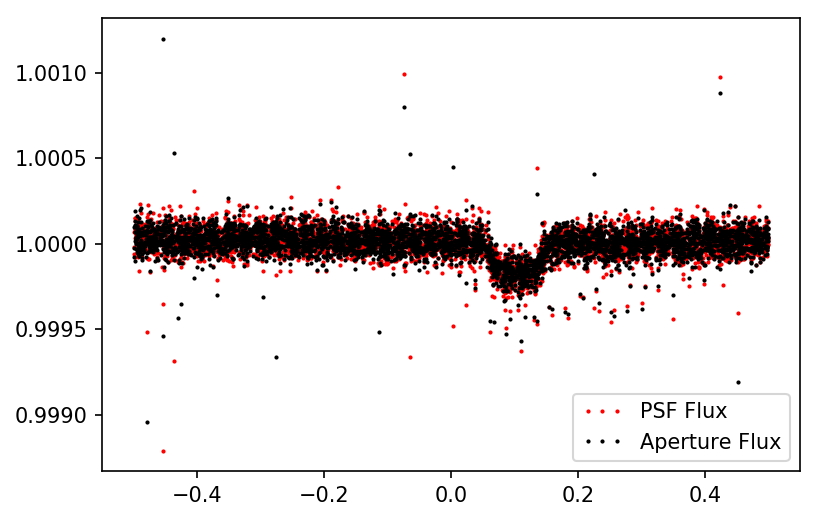

In [17]:
plt.plot(lc_psf.time, lc_psf.flux, 'ro', markersize=1, label='PSF Flux')
plt.plot(lc.time, lc.flux, 'ko', markersize=1, label='Aperture Flux')
plt.legend(numpoints=3)

I think that's ok for a pretty wrong model.